# Projet IF29 P22
### Détection des influenceurs sur Twitter en appliquant les méthodes non supervisée et supervisée

## Inserer les donnees dans MongoDB

### Créer la BD en utilisant le fichier 'Worldcup 200Tweets' sur moodle


In [1]:
from pymongo import MongoClient
import os
import json
import numpy as np
import pandas as pd
import time

In [2]:
FIRST_TIME_RUN = False

In [3]:
if FIRST_TIME_RUN:
    client = MongoClient('localhost', 27017)
    db = client['if29_projet'] # nom de BD
    collection = db['if29_projet'] #nom de collection
    parent_dir = ("raw/") #adresse de fichier
    list_filename = os.listdir(parent_dir)

    for filename in list_filename:
        filepath = parent_dir + filename
        with open(filepath, encoding='utf-8') as f:
            lines = f.readlines()
            f.close()
        for line in lines:
            document = json.loads(line[:-1])
            collection.insert_one(document)

## Connecter à la BD

In [4]:
if FIRST_TIME_RUN:
    client = MongoClient('localhost', 27017)
    db = client['if29_projet']
    collection = db['if29_projet']

## Créer le dataframe

### Créer le dataframe en utilisant les attributs qui nous intéressent concernant les utilisateurs


In [5]:
if FIRST_TIME_RUN:
    cursor = collection.aggregate(
        [
            {"$group" : {
                "_id" : "$user.id", 
                "friends_count" : {"$last" : "$user.friends_count"},
                "favourites_count" : {"$last" : "$user.favourites_count"},
                "statuses_count" : {"$last" : "$user.statuses_count"},
                "followers_count" : {"$last" : "$user.followers_count"},
                 "created_time" : {"$last" : "$user.created_at"}
            }
            }
        ],
        allowDiskUse=True,
    )
    df = pd.json_normalize(cursor)

### If we run the program for the first time, we pickle notre pandas dataframe, comme ca on n'a pas besoin de connecter au MongoDB a chaque fois.

In [6]:
if FIRST_TIME_RUN:
    df.to_pickle('twitter.pkl', protocol=4)
else:
    df = pd.read_pickle("twitter.pkl")

### Première analyse sur le résumé des données quantitatives

In [7]:
df.iloc[:,[1,2,3,4]].describe().astype(int)

,friends_count,favourites_count,statuses_count,followers_count
count,1843438,1843438,1843438,1843438
mean,870,8753,17675,3601
std,4889,22033,40482,118540
min,0,0,1,0
25%,168,443,1104,103
50%,357,2164,5204,298
75%,758,7922,17885,753
max,1569366,1718515,8909333,42198786


## Feature Engineering

### Calculer les indicateurs (attributs dérivés) ci-dessous destinés à la description des 'influenceurs'
- 1) Visibilité: Vis
- 2) Nombre moyen de 'aimer' par tweet: avg_fav 
- 3) Ratio entre nombre de 'abonné' et nombre de 'abonnement': r_fri_follow
- 4) la fréquence de publication de tweets depuis la création de compte jusqu'à t0 = 01/01/2019: frequency

### 1) Visibilité: Vis


In [8]:
if FIRST_TIME_RUN:
    # Regrouper les textes de tweet par chaque utilisateur
    cursor1 = collection.aggregate(
        [        
             {"$group" : {
                "_id" : "$user.id", 

                "tweets" : {"$push": "$text"}
            }
            }
        ],
        allowDiskUse=True
    )
    df1 = pd.json_normalize(cursor1)
    df1.to_pickle('df1.pkl', protocol=4)
else:
    df1 = pd.read_pickle('df1.pkl')

In [9]:
def calcul_visibility(row):
    s = 0
    for tweet in row["tweets"]:
        s += tweet.count("@")*11.4  # le coût moyen pour @ est 11,4
        s += tweet.count("#")*11.6  # le coût moyen pour # est 11,6 cf.fichier 'SPOT'
    return s/(140*len(row["tweets"]))

visibilities = df1.apply(calcul_visibility,axis=1)

### 2) Nombre moyen de 'aimer' par tweet: avg_fav


In [10]:
avg_fav = df.favourites_count/df.statuses_count

### 3) Ratio entre nombre de 'abonné' et nombre de 'abonnement': r_fri_follow

In [11]:
r_fri_follow = df.followers_count/df.friends_count

### 4) la fréquence de publication de tweets depuis la création de compte jusqu'à t0 = 01/01/2019: frequency

In [12]:
import time
def ratio(row):
    time_array = time.strptime(row["created_time"], "%a %b %d %H:%M:%S +0000 %Y")
    time_stamp = time.mktime(time_array)
    time_stamp_0 = time.mktime(time.strptime("Mon Jan 1 00:00:00 2019", '%a %b %d %H:%M:%S %Y'))
    # on multiplie une constante = 100 pour amplifier les résultats
    return row["statuses_count"]*100/(time_stamp_0 - time_stamp) 

frequency = df.apply(ratio, axis=1)  

### Générer un dataframe en regroupant les quatres indicateurs calculés

In [13]:
features = pd.DataFrame()
features["user_id"] = df.iloc[:,0]
features["vis"] = visibilities
features["r_fri_follow"] = r_fri_follow
features["avg_fav"] = avg_fav
features["frequency"] = frequency

### On supprime toutes les lignes qui contiennent 'Nan' ou 'inf'

In [14]:
pd.options.mode.use_inf_as_na = True
features.dropna(inplace=True)
features = features.reset_index(drop=True)

### On normalise les données pour effectuer les classifications


In [15]:
from sklearn import preprocessing

features_normalized = preprocessing.normalize(features.iloc[:,[1,2,3,4]])
features_normalized = pd.DataFrame(features_normalized)
features_normalized.columns = ['vis','r_fri_follow','avg_fav','frequency']
features_normalized

,vis,r_fri_follow,avg_fav,frequency
0,0.024957,0.996502,0.079755,0.000947
1,0.000000,0.986698,0.162562,0.000789
2,0.004236,0.999739,0.022437,0.000180
3,0.068294,0.974714,0.212763,0.000616
4,0.040957,0.989022,0.141976,0.000206
...,...,...,...,...
1832729,1.000000,0.000000,0.000000,0.000381
1832730,1.000000,0.000000,0.000000,0.000018
1832731,1.000000,0.000000,0.000000,0.000018
1832732,1.000000,0.000000,0.000000,0.000071


### On effectue l'ACP pour réduire les 4 dimensions

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features_standardized = StandardScaler().fit_transform(features.iloc[:,[1,2,3,4]]) #il faut centrer et réduire les données d'abord
# vérification
print("La moyenne : ",np.mean(features_standardized,axis=0))
print("L'écart type : ",np.std(features_standardized,axis=0))

acp = PCA(svd_solver='auto')
coord = acp.fit_transform(features_standardized) 
print(acp.explained_variance_ratio_) # les pourcentage de variance projectée sur chaque axe (composante principale)
coord # les coordonées des individus dans les nouveaux repères

La moyenne :  [-3.13630157e-16 -9.65361810e-19 -1.52674490e-17  5.70687785e-17]
L'écart type :  [1. 1. 1. 1.]
[0.25811879 0.25118505 0.24985585 0.2408403 ]


array([[ 0.42596149, -0.81684978,  0.18330679,  0.08457819],
       [ 0.48045645, -1.27408903,  0.31074178,  0.48710648],
       [ 0.41389715, -0.80223787,  0.18322466,  0.09804469],
       ...,
       [ 0.02779715,  0.70098496, -0.19473224, -0.73080405],
       [ 0.03004893,  0.69222588, -0.19257438, -0.72616199],
       [-0.27043817,  1.74735851, -0.44065788, -1.18148258]])

## Unsupervised learning (K-means)

### Basé sur le résultat d'ACP, on effectue le K-means dans le plan (1,2) qui se compose de deux composantes dont inerties les plus élevées 


In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

kmeans = KMeans(n_clusters=2, random_state=0) # Selon le sujet, ici on ne choisit que de classer en 2 clusters.
labels = kmeans.fit_predict(coord[:,[0,1]]) # on ne prend que les coordonées de l'axe 1 et 2

print(np.unique(labels, return_counts=True)) # afficher la condition de séparation

labels0 = coord[labels == 0]
labels1 = coord[labels == 1]

(array([0, 1], dtype=int32), array([1378293,  454441]))


### Plot K-means 

Pour voir plus clairement, on prend aléatoirement 100 points pour tracer le graphique

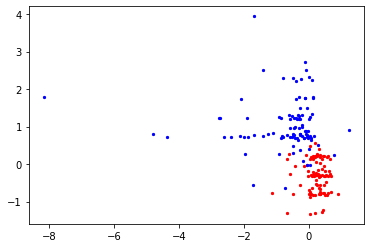

In [18]:
plt.scatter(np.random.choice(labels0[:,0],100), np.random.choice(labels0[:,1],100), c='red', s=5) 

plt.scatter(np.random.choice(labels1[:,0],100), np.random.choice(labels1[:,1],100), c='blue', s=5) 

### Avant de passer à l'approche supervisée, il faut d'abord labeliser les données. Dans cette étape on va utiliser un échantillon de taille 50000 pour entraîner le modèle. Comme on a 4 indicateurs, on décide de les combiner en utilisant la méthode d'entropie

## Labeliser les données

### Méthode d'entropie


In [19]:
data = features.iloc[:,[1,2,3,4]]
indicateur = data.columns.tolist()   ## nombre des indicateurs
profil = data.index.tolist()    ## nombre des profils
value = data.values

# définir la fonction de normalisation, on rajoute une constante 0,01
def std_data(value,flag):
    for i in range(len(indicateur)):
        if flag[i]=='+':
            value[:,i]=(value[:,i]-np.min(value[:,i],axis=0))/(np.max(value[:,i],axis=0)-np.min(value[:,i],axis=0))+0.01
        elif flag[i]=='-':
            value[:,i]=(np.max(value[:,i],axis=0)-value[:,i])/(np.max(value[:,i],axis=0)-np.min(value[:,i],axis=0))+0.01
    return value

# définir la fonction d'entropie et calculer les poids et les entropies
def cal_weight(indicateur,profil,value):
    p= np.array([[0.0 for i in range(len(indicateur))] for i in range(len(profil))])                    
    for i in range(len(indicateur)):
        p[:,i]=value[:,i]/np.sum(value[:,i],axis=0)
        
    e=-1/np.log(len(profil))*sum(p*np.log(p))      #calcul d'entropie
    g=1-e     
    w=g/sum(g)     #calcul des poids
    return w

# normalisation des données
flag=["+","+","+","+"]  ## '+' ou '-' désigne le sens positif ou négatif des indicateurs
std_value=std_data(value,flag)
std_value.round(3)

# Résultat
w=cal_weight(indicateur,profil,std_value)
w=pd.DataFrame(w,index=data.columns,columns=['Poids'])
print("#######Poids:#######")
print(w)
score=np.dot(std_value,w).round(2)
score=pd.DataFrame(score,index=data.index,columns=['Notes']).sort_values(by =['Notes'],ascending = False)

#######Poids:#######
                 Poids
vis           0.636514
r_fri_follow  0.002862
avg_fav       0.025274
frequency     0.335349


### la note de chaque utilisateur représente la correspondance avec les profils qu'on va détecter. Si une note plus élevée, le profil correspondant est plus probablement censé un influnceur

### A l'aide de résultat ci-dessus, on peut compter la fréquence de chaque note. Avec cela, on va ensuite calculer le pourcentage de fréquence cumulée. En vertu de principe de Pareto (80/20), on peut alors découper les données en 2 classes: les profils plus générals (la somme de fréquence représente environ 80% au total) et le reste plus critique (20%)

In [20]:
import collections
data1 = []
for i in range(len(score)):
    data1.append(score.iloc[i,0])

c = collections.Counter(data1) #créer un counter pour compter la fréquence de note

freq = np.array(list(dict(c).items()),dtype = 'float')
np.set_printoptions(suppress=True)
freq = freq[np.lexsort(-freq.T)] # ordonner par décroissant en fonction de fréquence

In [21]:
somme = 0
cumul = 0.00
cluster = []

for i in range(len(freq)):
    if cumul <= 0.81:          # 0.01 de tolérance 
        somme += freq[i,1].astype(int)
        cluster.append(freq[i,0])
        cumul = float(somme/len(data1))
    else: 
        break
    
print(cumul) # le pourcentage cumulé pour la classe 'générale'
print(cluster) #les notes de cette classe

0.8219758022713607
[0.06, 0.08, 0.03, 0.04, 0.11, 0.01, 0.07, 0.05]


### On va maintenant labeliser les profils en fonction de classes divisées ci-dessus


In [22]:
label = score.apply(lambda row: 1 if row["Notes"] in cluster else -1, axis=1 )
label

1153103   -1
967026    -1
16090     -1
199538    -1
5959      -1
          ..
674714     1
1280439    1
1280438    1
674722     1
515487     1
Length: 1832734, dtype: int64

## Supervised Learning - Method 1  (SVM)

### Application de la méthode SVM


In [23]:
data = features_normalized
data["label"] = label
data = data.sample(50000) # On prend un échantillon de taille 50000

X = data.iloc[:,[0,1,2,3]]
y = data.iloc[:,[4]]
X = X.to_numpy()
y = y.to_numpy().ravel()

In [24]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                    test_size=0.3, random_state=42) # On sépare les jeux d'entrâinement et de test         

svm_clf = svm.SVC()


start = time.time()
svm_clf.fit(X_train, y_train)
elapsed_time = time.time() - start
print(f"elapsed time for traing SVM model: {elapsed_time}")

elapsed time for traing SVM model: 28.98422384262085


In [25]:
y_pred = svm_clf.predict(X_test)
print(accuracy_score(y_test,y_pred),'\n',classification_report(y_test,y_pred))

0.8251333333333334 
               precision    recall  f1-score   support

          -1       0.55      0.04      0.08      2643
           1       0.83      0.99      0.90     12357

    accuracy                           0.83     15000
   macro avg       0.69      0.52      0.49     15000
weighted avg       0.78      0.83      0.76     15000



### On doit verifier si notre modele a overfit ou pas. Comme on le voit, puisque la precision de prediction est pareille sur X_train et sur X_test, on n'a pas le probleme de overfitting ici.

### Donc, on n'a pas besoin de faire la regularization etc.

In [26]:
y_pred_X_train = svm_clf.predict(X_train)
print(accuracy_score(y_train,y_pred_X_train))

0.8228571428571428


### plot confusion matrix

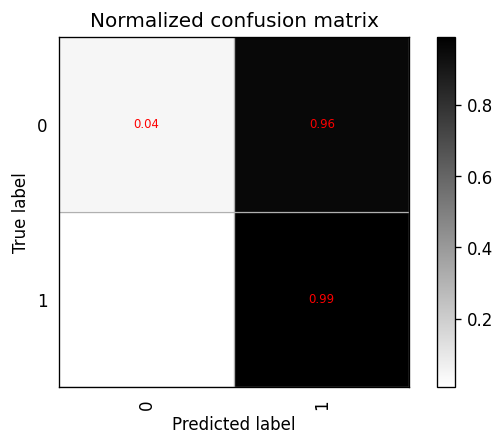

In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print(cm_normalized)

tick_marks = np.array(range(2)) + 0.5###

labels=range(2)###
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.binary):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(2))###
    plt.xticks(xlocations, labels, rotation=90)
    plt.yticks(xlocations, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure(figsize=(6, 4), dpi=120)

ind_array = np.arange(2)###
x, y = np.meshgrid(ind_array, ind_array)

for x_val, y_val in zip(x.flatten(), y.flatten()):
    c = cm_normalized[y_val][x_val]
    if c > 0.01:
        plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=7, va='center', ha='center')
# offset the tick
plt.gca().set_xticks(tick_marks, minor=True)
plt.gca().set_yticks(tick_marks, minor=True)
plt.gca().xaxis.set_ticks_position('none')
plt.gca().yaxis.set_ticks_position('none')
plt.grid(True, which='minor', linestyle='-')
plt.gcf().subplots_adjust(bottom=0.15)

plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

### The great disadvantage of SVM is that it takes too long for training. Therefore, we will try with Logistic Regression, a very simple classification model.

## Supervised Learning - Method 2 (Logistic Regression)

In [28]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()

start = time.time()
logistic_model.fit(X_train, y_train)
elapsed_time = time.time() - start
print(f"elapsed time for traing logistic regression model: {elapsed_time}")

y_pred = logistic_model.predict(X_test)
print(accuracy_score(y_test,y_pred),'\n',classification_report(y_test,y_pred))

elapsed time for traing logistic regression model: 0.22707128524780273
0.8245333333333333 
               precision    recall  f1-score   support

          -1       0.51      0.12      0.19      2643
           1       0.84      0.98      0.90     12357

    accuracy                           0.82     15000
   macro avg       0.67      0.55      0.55     15000
weighted avg       0.78      0.82      0.78     15000



In [29]:
y_pred_X_train = logistic_model.predict(X_train)
print(accuracy_score(y_train,y_pred_X_train))

0.8208571428571428


### As we can see, the training of logistic regression model is very very fast, much faster then SVM. The accuracy is just slightly behind SVM.